## Reviews
This is the reference implementation for [Reviews](https://github.com/chaoss/wg-evolution/blob/master/metrics/Reviews.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).
This implementation is specific to Git repositories.

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing Reviews
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation

As discussed in the [README](../README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `code_df` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `..` to `sys.path`, so that `code_df` can be successfully imported. 

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from code_df import utils
from code_df import conditions
from code_df.pullrequest import PullRequest
%matplotlib inline

In [2]:
class Reviews(PullRequest):
    """
    Class for Reviews
    """

    def compute(self):
        """
        Compute the total number of reviews created, from the Perceval data.

        :returns count: The total number of reviews created
        """

        count = len(self.df['hash'].unique())
        return count

    def _agg(self, df, period):
        """
        Perform an aggregation operation on a DataFrame to find
        the total number of reviews created in every
        interval of the period specified in the time_series method,
        like 'M', 'W',etc.

        It computes the count of the "category" column of the
        DataFrame.

        :param df: a pandas DataFrame on which the aggregation will be
            applied.

        :param period: A string which can be any one of the pandas time
            series rules:
            'W': week
            'M': month
            'D': day

        :returns df: The aggregated dataframe, where aggregations have
            been performed on the "category" column
        """

        df = df.resample(period)['category'].agg(['count'])

        return df

## Performing the Analysis
Using the above class, we can perform several kinds of analysis on the JSON data file, fetched by Perceval.

For starters, we can perform a simple count of all reviews in the data. For this analysis, we can vary the value passed to the `date_range` parameter.

### Counting the total number of commits 
We first read the JSON file containing Perceval data using the `read_json_file` utility function. 

In [3]:
items = utils.read_json_file('../pull_requests.json')

Let's use the `compute` method to count the total number of reviews created. First, we will do it without passing any since and until dates. 
Next, we can pass in the start and end dates as a tuple. The format would be `%Y-%m-%d`.

A third kind of analysis we can perform is passing only one of the dates to `date_range` --- either `since` or `until`.

In [4]:
reviews = Reviews(items)
print("The total number of reviews "
      "in the file is {}.".format(reviews.compute()))

date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")    

reviews_dated = Reviews(items,
                        date_range=(date_since, date_until))
                        
print("The total number of reviews created between "
      "2018-01-01 and 2018-07-01 is {}.".format(reviews_dated.compute()))

reviews_after = Reviews(items,
                        date_range=(date_since, None))
                        
print("The total number of reviews created after "
      "2018-01-01 is {}.".format(reviews_after.compute()))

The total number of reviews in the file is 229.
The total number of reviews created between 2018-01-01 and 2018-07-01 is 43.
The total number of reviews created after 2018-01-01 is 75.


## Counting reviews over regular time intervals
Using the `time_series` method, it is possible to compute the number of reviews created every month, or every week, or infact any valid pandas timeperiod. This kind of analysis is useful in finding trends over time, as we will see in the cell below.

Let's perform a basic analysis: lets see the change in the number of reviews created between the same dates we used above on a weekly basis: 2018-01-01 and 2018-07-01. 
The Reviews object, `reviews_dated`, will be the same as used above.

In [5]:
weekly_df = reviews_dated.time_series(period='W')

Lets see what the dataframe returned by `time_series` looks like. As you will notice, the dataframe has rows corresponding to each and every week between the start and end dates. To do this, we simply set the `created_date` column of the DataFrame `changes_dated.df`, as its index and then `resample` it to whatever time period we need. In this case, we have used `W`. 

In [6]:
weekly_df

,count
created_date,
2018-01-07,3
2018-01-14,4
2018-01-21,4
2018-01-28,2
2018-02-04,2
2018-02-11,5
2018-02-18,2
2018-02-25,1
2018-03-04,0


Lets plot the dataframe `weekly_df` using matplotlib.pyplot. We use the `seaborn` theme and plot a simple line plot --- commit count vs time interval. Using the `plt.fill_between` method allows us to "fill up" the area between the line plot and the x axis.

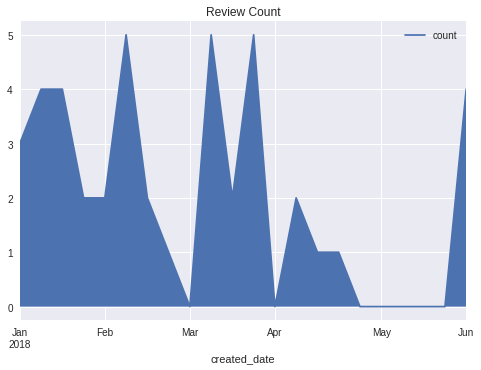

In [7]:
plt.style.use('seaborn')
weekly_df.plot(y='count', use_index=True)
plt.fill_between(y1=weekly_df['count'], y2=0, x=weekly_df.index)
plt.title("Review Count");

The same thing can be tried for months, instead of weeks. By passing `month` in place of week, we get a similar dataframe but with only a few rows, due to the larger timescale. 

In [8]:
monthly_df = reviews_dated.time_series('M')

In [9]:
monthly_df

,count
created_date,
2018-01-31,14
2018-02-28,9
2018-03-31,12
2018-04-30,4
2018-05-31,4


Lets plot it just like we did for `weekly_df`.

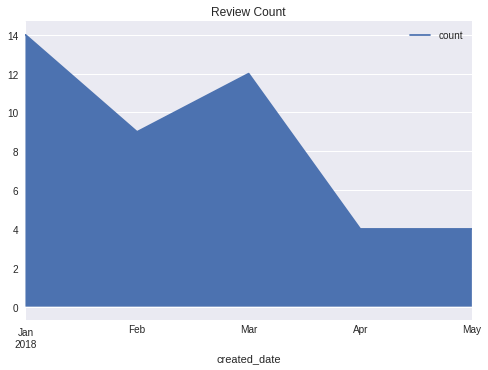

In [10]:
plt.style.use('seaborn')
monthly_df.plot(y='count', use_index=True)
plt.fill_between(y1=monthly_df['count'], y2=0, x=monthly_df.index)
plt.title("Review Count");